In [1]:
import numpy as np
import tifffile
import torch
import argparse
import itertools
import os
import random
import torch
import matplotlib.pyplot as plt
from collections import Counter
from dataclasses import dataclass
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from torch import nn
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

In [2]:
def get_autoencoder(out_channels=384):
    return nn.Sequential(
        # encoder
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2,
                  padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2,
                  padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2,
                  padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2,
                  padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2,
                  padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=8),
        # decoder
        nn.Upsample(size=3, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1,
                  padding=2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Upsample(size=8, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1,
                  padding=2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Upsample(size=15, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1,
                  padding=2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Upsample(size=32, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1,
                  padding=2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Upsample(size=63, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1,
                  padding=2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Upsample(size=127, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=1,
                  padding=2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Upsample(size=56, mode='bilinear'),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1,
                  padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=3,
                  stride=1, padding=1)
    )

def get_pdn_small(out_channels=384, padding=False):
    pad_mult = 1 if padding else 0
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4,
                  padding=3 * pad_mult),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1 * pad_mult),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4,
                  padding=3 * pad_mult),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1 * pad_mult),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,
                  padding=1 * pad_mult),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=out_channels, kernel_size=4)
    )

def get_pdn_medium(out_channels=384, padding=False):
    pad_mult = 1 if padding else 0
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=256, kernel_size=4,
                  padding=3 * pad_mult),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1 * pad_mult),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4,
                  padding=3 * pad_mult),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1 * pad_mult),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,
                  padding=1 * pad_mult),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=out_channels, kernel_size=4),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                  kernel_size=1)
    )

class ImageFolderWithoutTarget(ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        return sample

class ImageFolderWithPath(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample, target = super().__getitem__(index)
        return sample, target, path


def InfiniteDataloader(loader):
    iterator = iter(loader)
    while True:
        try:
            yield next(iterator)
        except StopIteration:
            iterator = iter(loader)

In [13]:
def train_transform(image):
    return default_transform(image), default_transform(transform_ae(image))

@torch.no_grad()
def teacher_normalization(teacher, train_loader):

    mean_outputs = []
    for train_image, _ in tqdm(train_loader, desc='Computing mean of features'):
    # for train_image, _ in train_loader:
        if on_gpu:
            train_image = train_image.cuda()
        teacher_output = teacher(train_image)
        mean_output = torch.mean(teacher_output, dim=[0, 2, 3])
        mean_outputs.append(mean_output)
    channel_mean = torch.mean(torch.stack(mean_outputs), dim=0)
    channel_mean = channel_mean[None, :, None, None]

    mean_distances = []
    for train_image, _ in train_loader:
        if on_gpu:
            train_image = train_image.cuda()
        teacher_output = teacher(train_image)
        distance = (teacher_output - channel_mean) ** 2
        mean_distance = torch.mean(distance, dim=[0, 2, 3])
        mean_distances.append(mean_distance)
    channel_var = torch.mean(torch.stack(mean_distances), dim=0)
    channel_var = channel_var[None, :, None, None]
    channel_std = torch.sqrt(channel_var)

    return channel_mean, channel_std

def test(test_set, teacher, student, autoencoder, teacher_mean, teacher_std,
         q_st_start, q_st_end, q_ae_start, q_ae_end, test_output_dir=None,
         desc='Running inference'):
    y_true = []
    y_score = []
    for image, target, path in tqdm(test_set, desc=desc):
    # for image, target, path in test_set:
        orig_width = image.width
        orig_height = image.height
        image = default_transform(image)
        image = image[None]
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
            q_ae_start=q_ae_start, q_ae_end=q_ae_end)
        map_combined = torch.nn.functional.pad(map_combined, (4, 4, 4, 4))
        map_combined = torch.nn.functional.interpolate(
            map_combined, (orig_height, orig_width), mode='bilinear')
        map_combined = map_combined[0, 0].cpu().numpy()

        defect_class = os.path.basename(os.path.dirname(path))
        if test_output_dir is not None:
            img_nm = os.path.split(path)[1].split('.')[0]
            if not os.path.exists(os.path.join(test_output_dir, defect_class)):
                os.makedirs(os.path.join(test_output_dir, defect_class))
            file = os.path.join(test_output_dir, defect_class, img_nm + '.tiff')
            tifffile.imwrite(file, map_combined)

        y_true_image = 0 if defect_class == 'good' else 1
        y_score_image = np.max(map_combined)
        y_true.append(y_true_image)
        y_score.append(y_score_image)
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    return auc * 100, y_true, y_score

def test_gkd(test_set, teacher, student, autoencoder, teacher_mean, teacher_std,
         q_st_start, q_st_end, q_ae_start, q_ae_end, test_output_dir=None,
         desc='Running inference'):
    y_true = []
    y_score = []
    defect_class_counter = Counter()
    image_groups = defaultdict(list)

    # Group images based on the first digit // 14 and the target
    for image, target, path in test_set:
        image_name = os.path.basename(path)
        group_id = (int(image_name.split('_')[0]) // 14, 'good' if target == 0 else 'bad')
        image_groups[group_id].append((image, target, path))

    for group_id, group in tqdm(image_groups.items(), desc=desc):
        group_maps = []
        group_label = 1 if group_id[1] == 'bad' else 0

        for image, target, path in group:
            orig_width = image.width
            orig_height = image.height
            image = default_transform(image)
            image = image[None]
            if on_gpu:
                image = image.cuda()
            
            map_combined, map_st, map_ae = predict(
                image=image, teacher=teacher, student=student,
                autoencoder=autoencoder, teacher_mean=teacher_mean,
                teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
                q_ae_start=q_ae_start, q_ae_end=q_ae_end)
            
            map_combined = torch.nn.functional.pad(map_combined, (4, 4, 4, 4))
            map_combined = torch.nn.functional.interpolate(
                map_combined, (orig_height, orig_width), mode='bilinear')
            map_combined = map_combined[0, 0].cpu().numpy()
            group_maps.append(map_combined)

            defect_class = 'good' if target == 0 else 'bad'
            defect_class_counter[defect_class] += 1

            if test_output_dir is not None:
                img_nm = os.path.split(path)[1].split('.')[0]
                out_dir = os.path.join(test_output_dir, defect_class)
                os.makedirs(out_dir, exist_ok=True)
                file = os.path.join(out_dir, img_nm + '.tiff')
                tifffile.imwrite(file, map_combined)

        # Use the maximum anomaly score from the group
        y_score_group = np.max([np.max(m) for m in group_maps])

        y_true.append(group_label)
        y_score.append(y_score_group)

    diagnostics = {
        "defect_class_distribution": dict(defect_class_counter),
        "y_true_distribution": dict(Counter(y_true)),
        "y_score_range": [min(y_score), max(y_score)]
    }

    # print(f"Defect class distribution: {diagnostics['defect_class_distribution']}")
    # print(f"y_true distribution: {diagnostics['y_true_distribution']}")
    # print(f"y_score range: {diagnostics['y_score_range']}")

    if len(set(y_true)) < 2:
        raise ValueError(f"Only one class present in the labels: {set(y_true)}. "
                         f"Defect classes found: {list(defect_class_counter.keys())}. "
                         f"ROC AUC score cannot be calculated.")

    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    return auc * 100, y_true, y_score

@torch.no_grad()
def predict(image, teacher, student, autoencoder, teacher_mean, teacher_std,
            q_st_start=None, q_st_end=None, q_ae_start=None, q_ae_end=None):
    teacher_output = teacher(image)
    teacher_output = (teacher_output - teacher_mean) / teacher_std
    student_output = student(image)
    autoencoder_output = autoencoder(image)
    map_st = torch.mean((teacher_output - student_output[:, :out_channels])**2,
                        dim=1, keepdim=True)
    map_ae = torch.mean((autoencoder_output -
                         student_output[:, out_channels:])**2,
                        dim=1, keepdim=True)
    if q_st_start is not None:
        map_st = 0.1 * (map_st - q_st_start) / (q_st_end - q_st_start)
    if q_ae_start is not None:
        map_ae = 0.1 * (map_ae - q_ae_start) / (q_ae_end - q_ae_start)
    map_combined = 0.5 * map_st + 0.5 * map_ae
    return map_combined, map_st, map_ae

@torch.no_grad()
def map_normalization(validation_loader, teacher, student, autoencoder,
                      teacher_mean, teacher_std, desc='Map normalization'):
    maps_st = []
    maps_ae = []
    # ignore augmented ae image
    for image, _ in tqdm(validation_loader, desc=desc):
    # for image, _ in validation_loader:
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std)
        maps_st.append(map_st)
        maps_ae.append(map_ae)
    maps_st = torch.cat(maps_st)
    maps_ae = torch.cat(maps_ae)
    q_st_start = torch.quantile(maps_st, q=0.9)
    q_st_end = torch.quantile(maps_st, q=0.995)
    q_ae_start = torch.quantile(maps_ae, q=0.9)
    q_ae_end = torch.quantile(maps_ae, q=0.995)
    return q_st_start, q_st_end, q_ae_start, q_ae_end

def main(config):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed) 

    if config.dataset == 'mvtec_ad' or config.dataset == 'gkd':
        dataset_path = config.mvtec_ad_path
    else:
        raise Exception('Unknown config.dataset')

    pretrain_penalty = True
    if config.imagenet_train_path == 'none':
        pretrain_penalty = False
    
    # create output dir
    train_output_dir = os.path.join(config.output_dir, 'trainings',
                                    config.dataset, config.subdataset)
    test_output_dir = os.path.join(config.output_dir, 'anomaly_maps',
                                   config.dataset, config.subdataset, 'test')
    try:
        os.makedirs(train_output_dir)
        os.makedirs(test_output_dir)
    except:
        pass

    # load data
    full_train_set = ImageFolderWithoutTarget(
        os.path.join(dataset_path, config.subdataset, 'train'),
        transform=transforms.Lambda(train_transform))
    test_set = ImageFolderWithPath(
        os.path.join(dataset_path, config.subdataset, 'test'))

    if config.dataset == 'mvtec_ad' or config.dataset == 'gkd':
        # mvtec dataset paper recommend 10% validation set
        train_size = int(0.9 * len(full_train_set))
        validation_size = len(full_train_set) - train_size
        rng = torch.Generator().manual_seed(seed)
        train_set, validation_set = torch.utils.data.random_split(full_train_set,
                                                           [train_size,
                                                            validation_size],
                                                           rng)
    else:
        raise Exception('Unknown config.dataset')

    train_loader = DataLoader(train_set, batch_size=12, shuffle=True,
                              num_workers=2, pin_memory=True)
    train_loader_infinite = InfiniteDataloader(train_loader)
    validation_loader = DataLoader(validation_set, batch_size=1)

    if pretrain_penalty:
        # load pretraining data for penalty
        penalty_transform = transforms.Compose([
            transforms.Resize((2 * image_size, 2 * image_size)),
            transforms.RandomGrayscale(0.3),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,
                                                                  0.225])
        ])
        penalty_set = ImageFolderWithoutTarget(config.imagenet_train_path,
                                               transform=penalty_transform)
        penalty_loader = DataLoader(penalty_set, batch_size=12, shuffle=True,
                                    num_workers=2, pin_memory=True)
        penalty_loader_infinite = InfiniteDataloader(penalty_loader)
    else:
        penalty_loader_infinite = itertools.repeat(None)

    # create models
    if config.model_size == 'small':
        teacher = get_pdn_small(out_channels)
        student = get_pdn_small(2 * out_channels)
    elif config.model_size == 'medium':
        teacher = get_pdn_medium(out_channels)
        student = get_pdn_medium(2 * out_channels)
    else:
        raise Exception()

    state_dict = torch.load(config.weights, map_location='cuda' if on_gpu else 'cpu')
    teacher.load_state_dict(state_dict)
    autoencoder = get_autoencoder(out_channels)
    
    # teacher frozen
    teacher.eval()
    student.train()
    autoencoder.train()


    if on_gpu:
        teacher.cuda()
        student.cuda()
        autoencoder.cuda()

    teacher_mean, teacher_std = teacher_normalization(teacher, train_loader)
    
    optimizer = torch.optim.Adam(itertools.chain(student.parameters(),
                                                 autoencoder.parameters()),
                                 lr=1e-4, weight_decay=1e-5)
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=int(0.95 * config.train_steps), gamma=0.1)

    tqdm_obj = tqdm(range(config.train_steps))
    for iteration, (image_st, image_ae), image_penalty in zip(
            tqdm_obj, train_loader_infinite, penalty_loader_infinite):

    # for iteration, (image_st, image_ae), image_penalty in zip(
        # range(config.train_steps), train_loader_infinite, penalty_loader_infinite):
        if on_gpu:
            image_st = image_st.cuda()
            image_ae = image_ae.cuda()
            if image_penalty is not None:
                image_penalty = image_penalty.cuda()
        with torch.no_grad():
            teacher_output_st = teacher(image_st)
            teacher_output_st = (teacher_output_st - teacher_mean) / teacher_std
        student_output_st = student(image_st)[:, :out_channels]
        distance_st = (teacher_output_st - student_output_st) ** 2
        d_hard = torch.quantile(distance_st, q=0.999)
        loss_hard = torch.mean(distance_st[distance_st >= d_hard])
    
        if image_penalty is not None:
            student_output_penalty = student(image_penalty)[:, :out_channels]
            loss_penalty = torch.mean(student_output_penalty**2)
            loss_st = loss_hard + loss_penalty
        else:
            loss_st = loss_hard
    
        ae_output = autoencoder(image_ae)
        with torch.no_grad():
            teacher_output_ae = teacher(image_ae)
            teacher_output_ae = (teacher_output_ae - teacher_mean) / teacher_std
        student_output_ae = student(image_ae)[:, out_channels:]
        distance_ae = (teacher_output_ae - ae_output)**2
        distance_stae = (ae_output - student_output_ae)**2
        loss_ae = torch.mean(distance_ae)
        loss_stae = torch.mean(distance_stae)
        loss_total = loss_st + loss_ae + loss_stae
    
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        scheduler.step()
    
        # if iteration % 10 == 0:
            # tqdm_obj.set_description(
                # "Current loss: {:.4f}  ".format(loss_total.item()))
    
        if iteration % 1000 == 0:
            torch.save(teacher, os.path.join(train_output_dir,
                                             'teacher_tmp.pth'))
            torch.save(student, os.path.join(train_output_dir,
                                             'student_tmp.pth'))
            torch.save(autoencoder, os.path.join(train_output_dir,
                                                 'autoencoder_tmp.pth'))
    
        if iteration % 10000 == 0 and iteration > 0:
            # run intermediate evaluation
            teacher.eval()
            student.eval()
            autoencoder.eval()
    
            q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
                validation_loader=validation_loader, teacher=teacher,
                student=student, autoencoder=autoencoder,
                teacher_mean=teacher_mean, teacher_std=teacher_std,
                desc='Intermediate map normalization')
            if config.dataset == 'mvtec_ad':
                auc1,_,_ = test(
                    test_set=test_set, teacher=teacher, student=student,
                    autoencoder=autoencoder, teacher_mean=teacher_mean,
                    teacher_std=teacher_std, q_st_start=q_st_start,
                    q_st_end=q_st_end, q_ae_start=q_ae_start, q_ae_end=q_ae_end,
                    test_output_dir=None, desc='Intermediate inference')
                print('Intermediate image auc: {:.4f}'.format(auc1))
            elif config.dataset == 'gkd':
                auc1,_,_ = test_gkd(
                    test_set=test_set, teacher=teacher, student=student,
                    autoencoder=autoencoder, teacher_mean=teacher_mean,
                    teacher_std=teacher_std, q_st_start=q_st_start,
                    q_st_end=q_st_end, q_ae_start=q_ae_start, q_ae_end=q_ae_end,
                    test_output_dir=None, desc='Intermediate inference')
                print('Intermediate image auc: {:.4f}'.format(auc1))
            else:
                print("Unknow Dataset!")
    
            # teacher frozen
            teacher.eval()
            student.train()
            autoencoder.train()
    
    teacher.eval()
    student.eval()
    autoencoder.eval()
    
    torch.save(teacher, os.path.join(train_output_dir, 'teacher_final.pth'))
    torch.save(student, os.path.join(train_output_dir, 'student_final.pth'))
    torch.save(autoencoder, os.path.join(train_output_dir,
                                         'autoencoder_final.pth'))
    
    q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
        validation_loader=validation_loader, teacher=teacher, student=student,
        autoencoder=autoencoder, teacher_mean=teacher_mean,
        teacher_std=teacher_std, desc='Final map normalization')
    
    if config.dataset == 'mvtec_ad':
        auc1, y_true, y_score = test(
            test_set=test_set, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
            q_ae_start=q_ae_start, q_ae_end=q_ae_end,
            test_output_dir=test_output_dir, desc='Final inference')
    elif config.dataset == 'gkd':
        auc1, y_true, y_score = test_gkd(
            test_set=test_set, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
            q_ae_start=q_ae_start, q_ae_end=q_ae_end,
            test_output_dir=test_output_dir, desc='Final inference')
    else:
        print("Unknow Dataset!")
        
    # print(f"Y_score: {y_score}")

    def plot_roc_curve(y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
        return roc_auc
    y_score = 1-np.array(y_score)
    auc_score = plot_roc_curve(y_true, y_score)
    
    print('Final image auc: {:.4f}'.format(auc_score))
    # print(f"Y_tue: {y_true}")

    def find_optimal_threshold(y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        
        distances = np.sqrt(fpr**2 + (1-tpr)**2)
        
        optimal_idx = np.argmin(distances)
        
        optimal_threshold = thresholds[optimal_idx]
        
        return optimal_threshold
        
    optimal_threshold = find_optimal_threshold(y_true, y_score)
    print(f"Optimal threshold: {optimal_threshold}")
    
    # Classify images based on the optimal threshold
    predictions = (np.array(y_score) >= optimal_threshold).astype(int)
    
    # Calculate and print metrics
    accuracy = np.mean(predictions == y_true)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.4f}")
    


In [14]:
# constants
seed = 42
on_gpu = torch.cuda.is_available()
out_channels = 384
image_size = 256

# data loading
default_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_ae = transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.2),
    transforms.ColorJitter(saturation=0.2)
])

In [21]:
@dataclass
class CONFIG:
    # dataset: str='mvtec_ad'
    dataset: str='gkd'
    # mvtec_ad_path: str='./workspace/mvtec_anomaly_detection_original'
    mvtec_ad_path: str='./workspace/gkd_efficientAD'
    imagenet_train_path: str='none'
    output_dir: str='./workspace/experiment/efficientad'
    subdataset: str='DC0'
    model_size: str='medium'
    weights: str='./workspace/experiment/efficientad/model_weights/teacher_medium.pth'
    # train_steps: int=70000
    train_steps: int=500

In [22]:
%matplotlib inline

/tmp/ipykernel_1283407/3227859659.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.weights, map_location='cuda' if on_gpu else 'cpu')
Fin

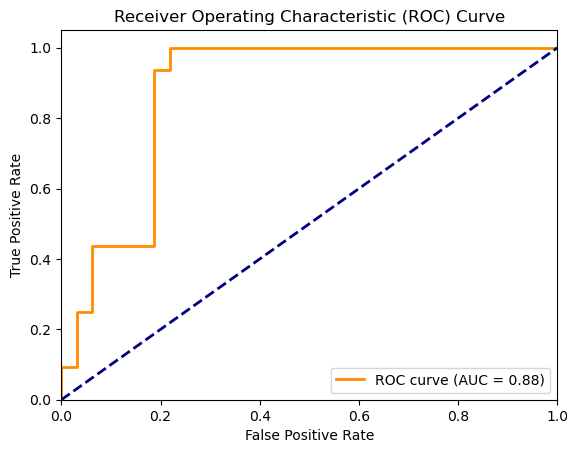

Final image auc: 0.8760
Optimal threshold: 0.23069000244140625
Accuracy: 0.88
Precision: 0.83
Recall: 0.94
F1-score: 0.8824


In [23]:
config = CONFIG()
main(config)